# Task 2: Decision Trees for Human Activity Recognition

### Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from MakeDataset import X_train, X_test, y_train, y_test
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from MakeDataset import X_train, X_test, y_train, y_test
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
from tqdm import tqdm

## 1. Use Sklearn Library to Train Decision Trees. [1.5 marks]

1. Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall, and confusion matrix of the model.
2. Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall, and confusion matrix of the model.
3. Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall, and confusion matrix of the model.

### Decision Tree using raw accelerometer data

- We have 30 subjects, each performing 6 activities. The accelerometer time series data is obtained by calling the utility file "MakeDataset.py".
- For each individual subject and activity, the time series data consists of 500 timesteps with 3 features (accelerometer data in x, y, z directions).
- To flatten the data, the time series is reshaped into 1500 features (500 timesteps * 3 features) for each subject and activity, with one activity label. 
- A Decision Tree Classifier is trained on this flattened data, and the decision tree is visualized.
- The decision tree is quite large and complex, but it shows how the classifier is able to distinguish between the different activities nevertheless.


In [ ]:
classes = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train shape: (126, 500, 3)
X_test shape: (54, 500, 3)
y_train shape: (126,)
y_test shape: (54,)
X_train_flat shape: (126, 1500)
X_test_flat shape: (54, 1500)


In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



#### Classification report

In [ ]:

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Classification Report:
                     precision    recall  f1-score   support

           WALKING       0.25      0.33      0.29         9
  WALKING_UPSTAIRS       0.38      0.33      0.35         9
WALKING_DOWNSTAIRS       0.50      0.22      0.31         9
           SITTING       0.67      0.89      0.76         9
          STANDING       0.78      0.78      0.78         9
            LAYING       1.00      1.00      1.00         9

          accuracy                           0.59        54
         macro avg       0.59      0.59      0.58        54
      weighted avg       0.59      0.59      0.58        54

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 0.2500, Recall = 0.3333, Accuracy = 0.7222
Class WALKING_UPSTAIRS: Precision = 0.3750, Recall = 0.3333, Accuracy = 0.7963
Class WALKING_DOWNSTAIRS: Precision = 0.5000, Recall = 0.2222, Accuracy = 0.8333
Class SITTING: Precision = 0.6667, Recall = 0.8889, Accuracy = 0.9074
Class STANDING: Precision

#### Visualizing the Decision Tree

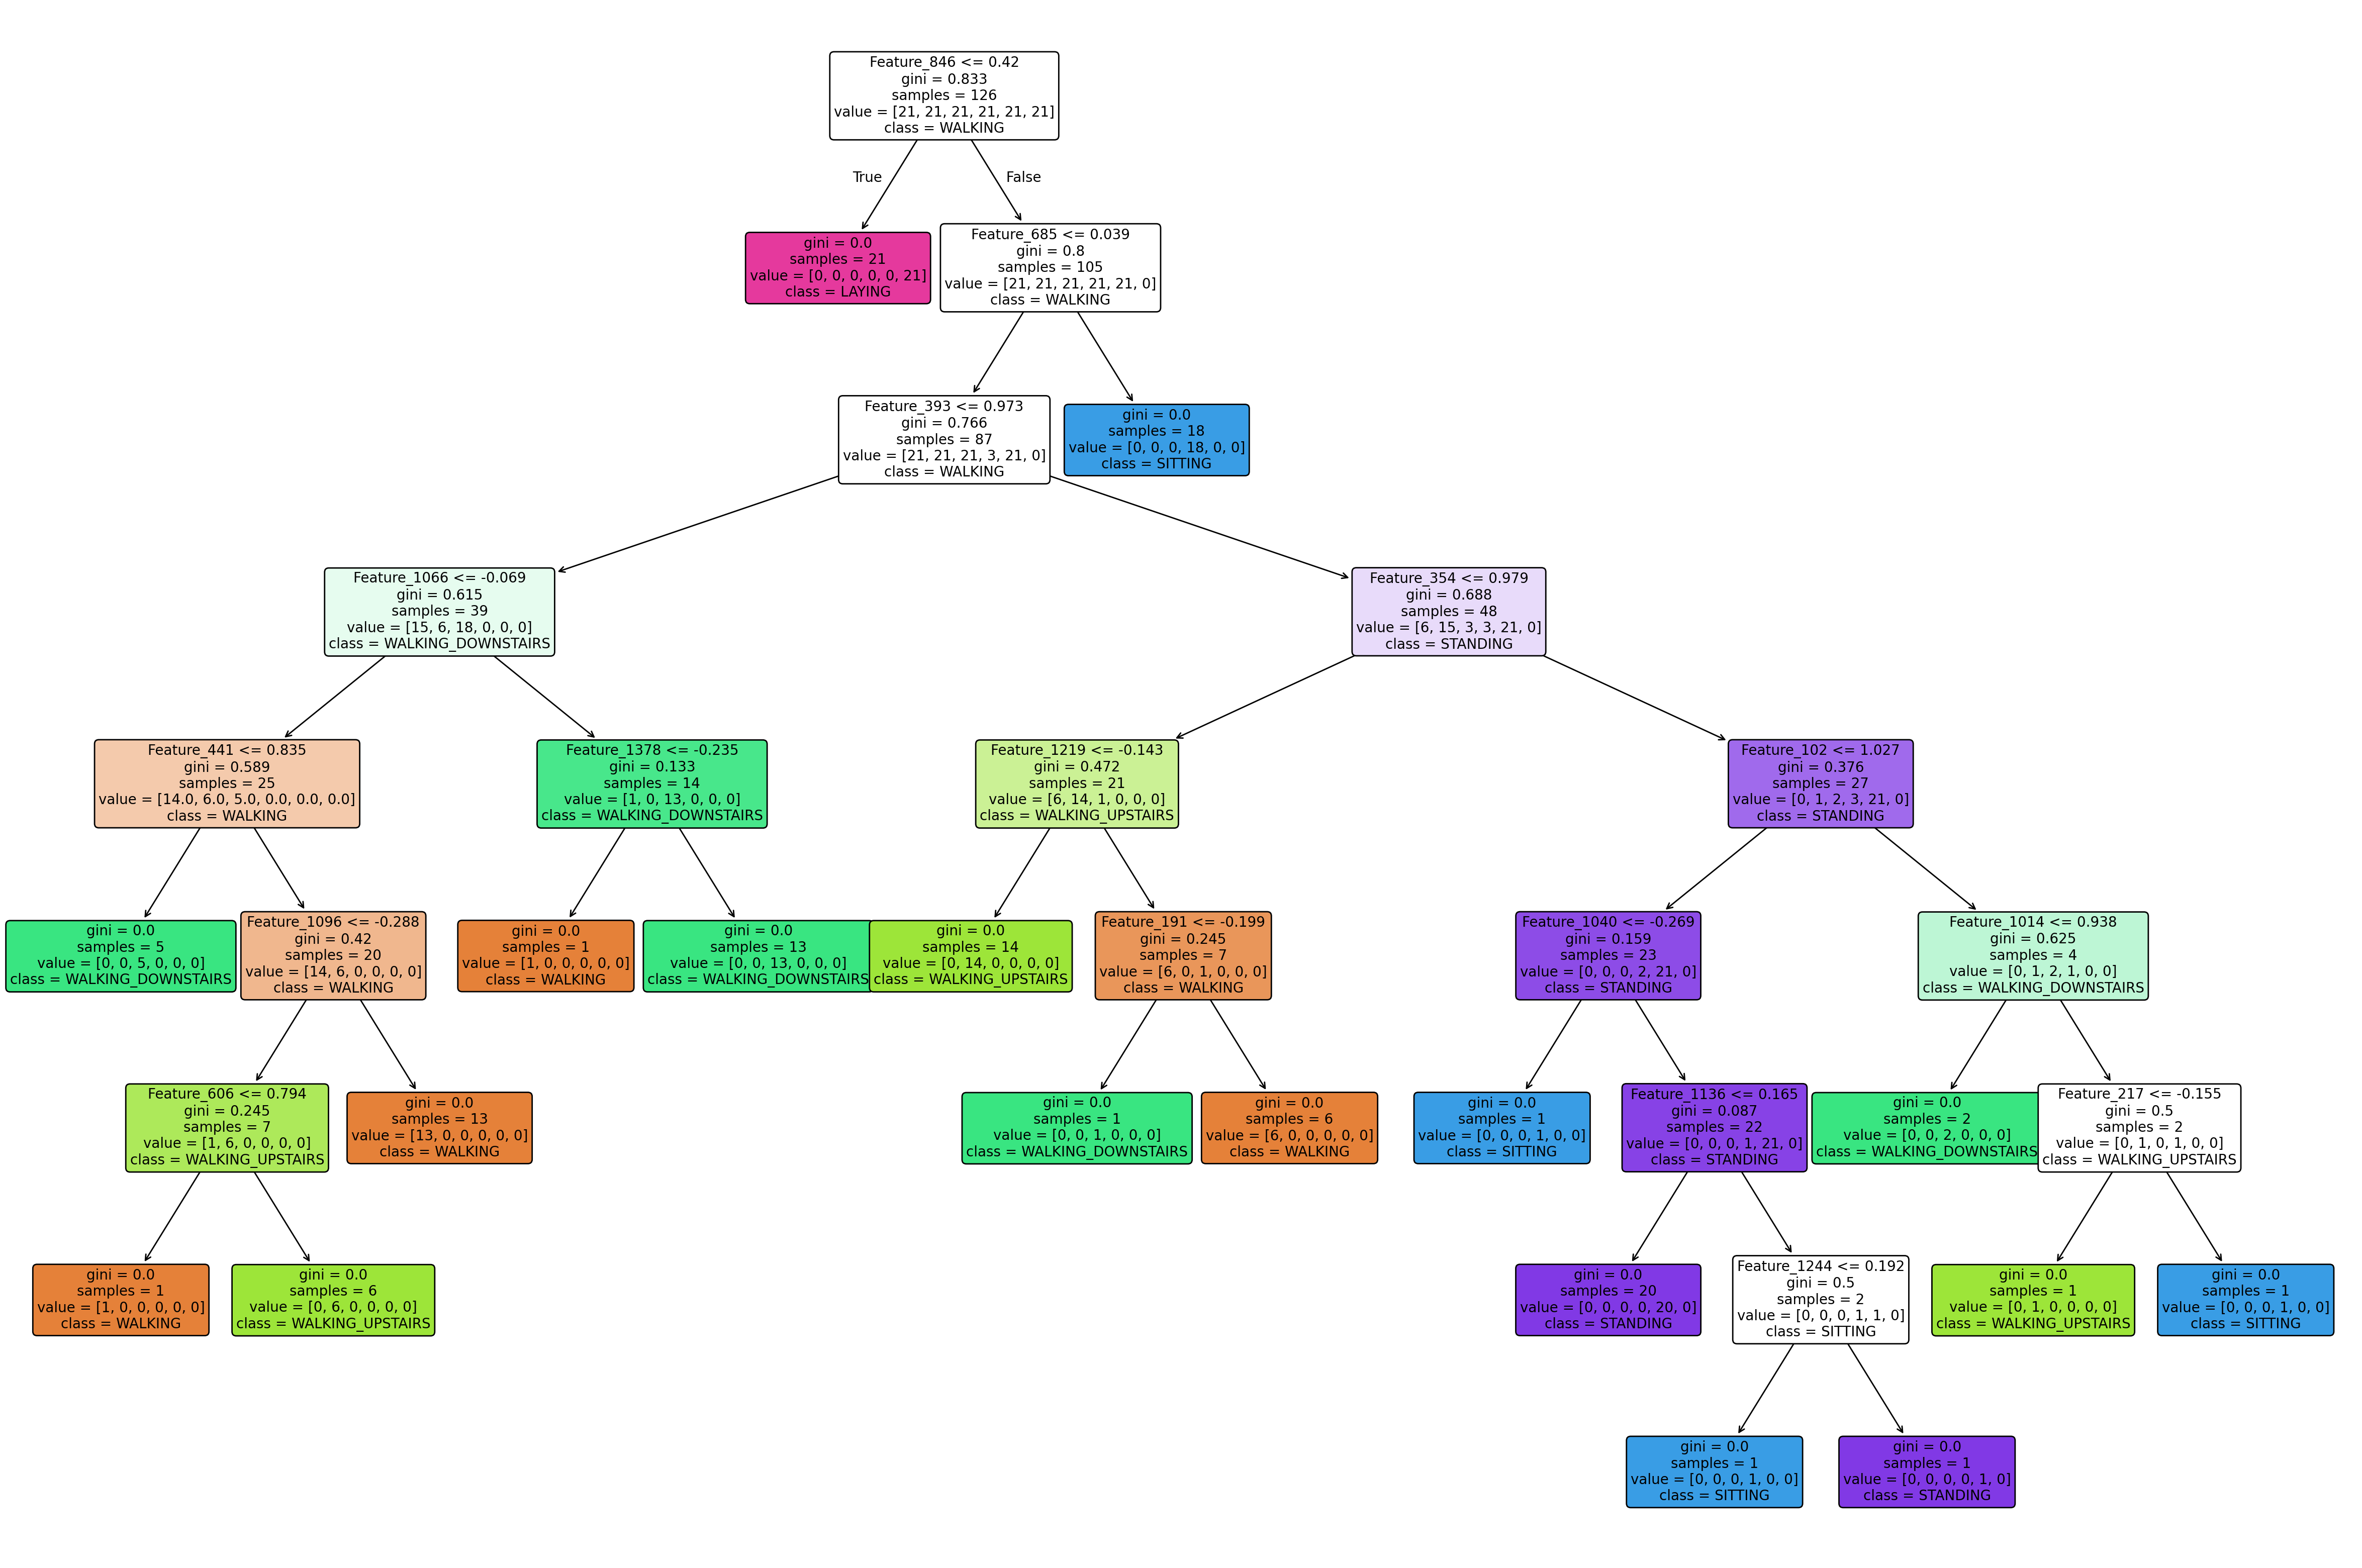

In [ ]:
plt.figure(figsize=(30, 20))
plot_tree(clf, 
          filled=True, 
          rounded=True, 
          feature_names=[f'Feature_{i}' for i in range(X_train_flat.shape[1])], 
          class_names=[classes[i] for i in sorted(classes.keys())],
          fontsize=10)    

plt.show()


#### Confusion Matrix

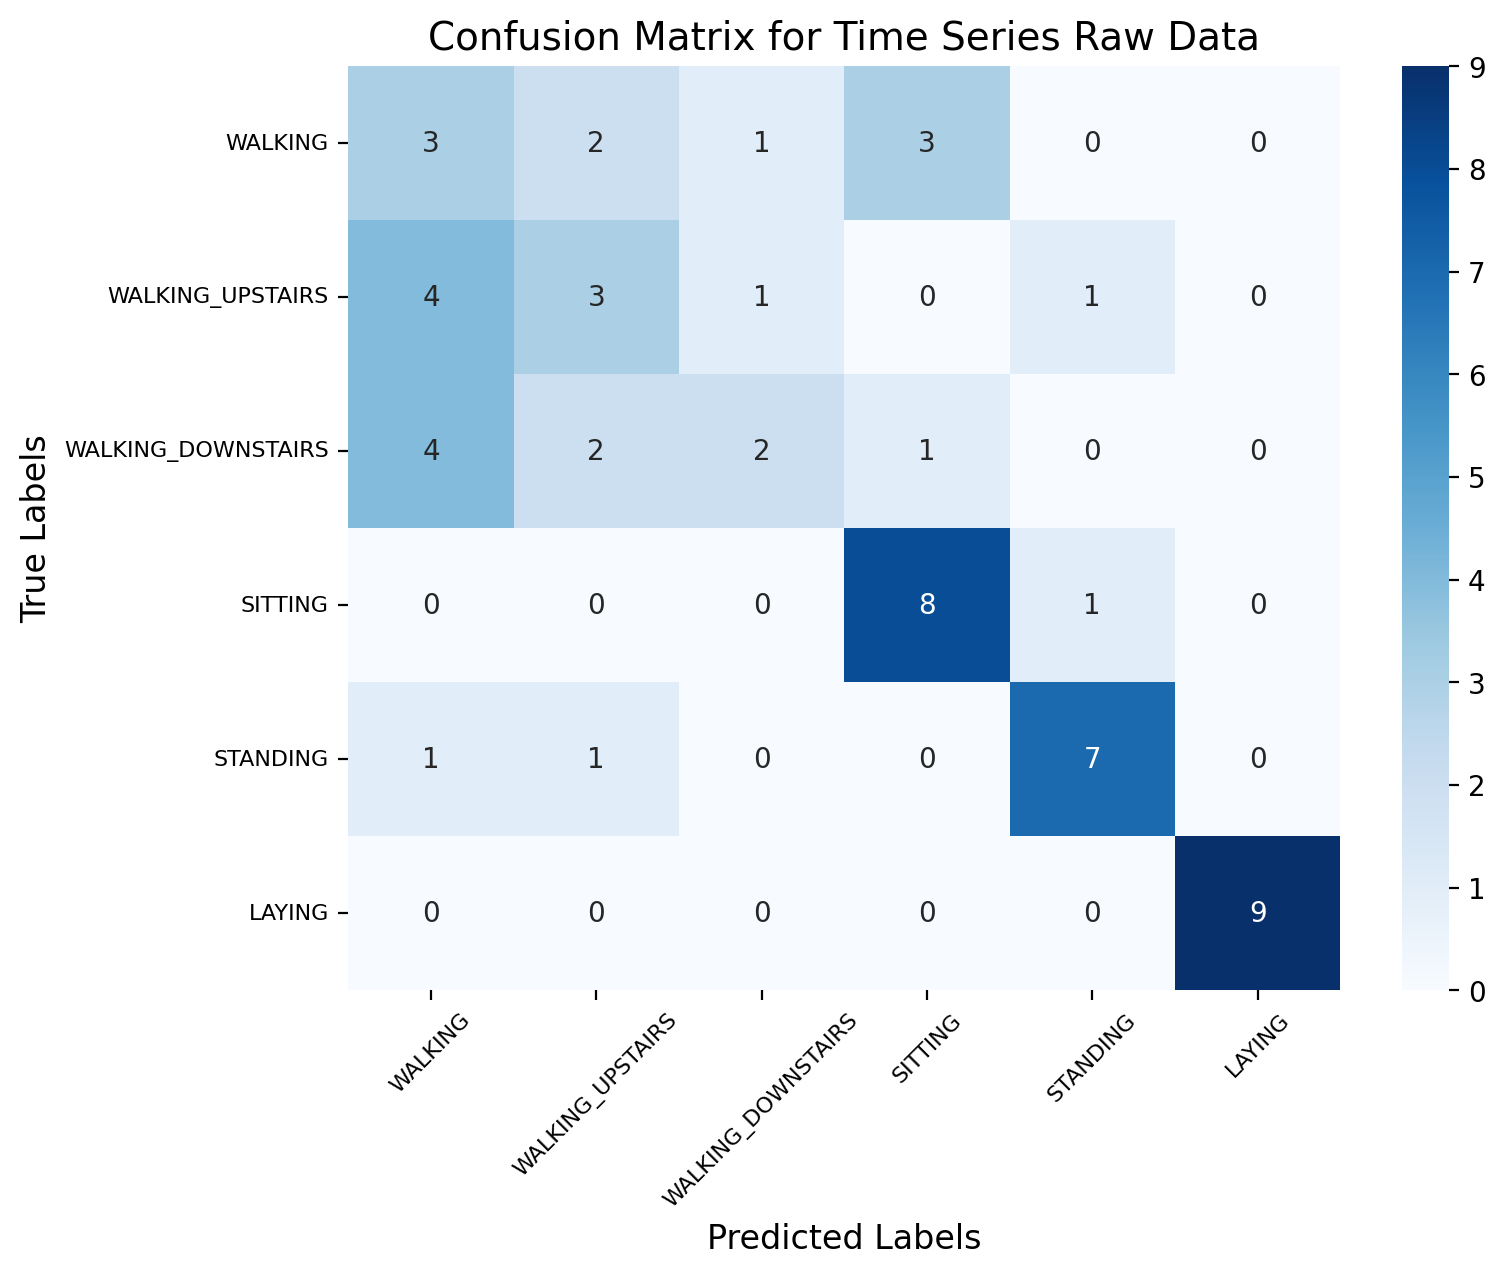

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)  
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)

plt.show()


### Passing TSFEL data as features

- Here, we are passing the filtered list of features obtained by TSFEL as input to the Decision Tree Classifier.
- The features are extracted from the raw accelerometer data using the TSFEL library, and the redundant features are removed using ANOVA F-test in task 1. 
- The features are passed to the Decision Tree Classifier, and the accuracy, precision, recall, and confusion matrix are reported.

In [ ]:
def load_tsfel_dataset(base_dir, dataset_type):
    activities = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

    data = []
    labels = []
    
    for activity in activities:
        folder_path = os.path.join(base_dir, dataset_type, activity)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path)
                
                num_timesteps, num_features = df.shape
                
                subject_data = df.values.reshape((num_timesteps, num_features))  # Shape: (500, 3)
                
                data.append(subject_data)
                labels.append(activity)
    
    data = np.array(data)  # Shape: (num_subjects, num_timesteps, num_features)
    labels = np.array(labels) 
    
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    return data, labels_encoded

base_dir = 'Datasets/TSFEL_3axes_filteredfeatures'

X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")


X_train shape: (126, 1, 60)
y_train shape: (126,)
X_test shape: (54, 1, 60)
y_test shape: (54,)
X_train_flat shape: (126, 60)
X_test_flat shape: (54, 60)


In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



#### Classification report

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Classification Report:
                     precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         9
  WALKING_UPSTAIRS       0.67      0.67      0.67         9
WALKING_DOWNSTAIRS       0.67      0.67      0.67         9
           SITTING       1.00      1.00      1.00         9
          STANDING       0.88      0.78      0.82         9
            LAYING       0.80      0.89      0.84         9

          accuracy                           0.83        54
         macro avg       0.83      0.83      0.83        54
      weighted avg       0.83      0.83      0.83        54

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 1.0000, Recall = 1.0000, Accuracy = 0.8889
Class WALKING_UPSTAIRS: Precision = 0.6667, Recall = 0.6667, Accuracy = 0.8889
Class WALKING_DOWNSTAIRS: Precision = 0.6667, Recall = 0.6667, Accuracy = 1.0000
Class SITTING: Precision = 1.0000, Recall = 1.0000, Accuracy = 0.9444
Class STANDING: Precision

#### Visualizing the Decision Tree

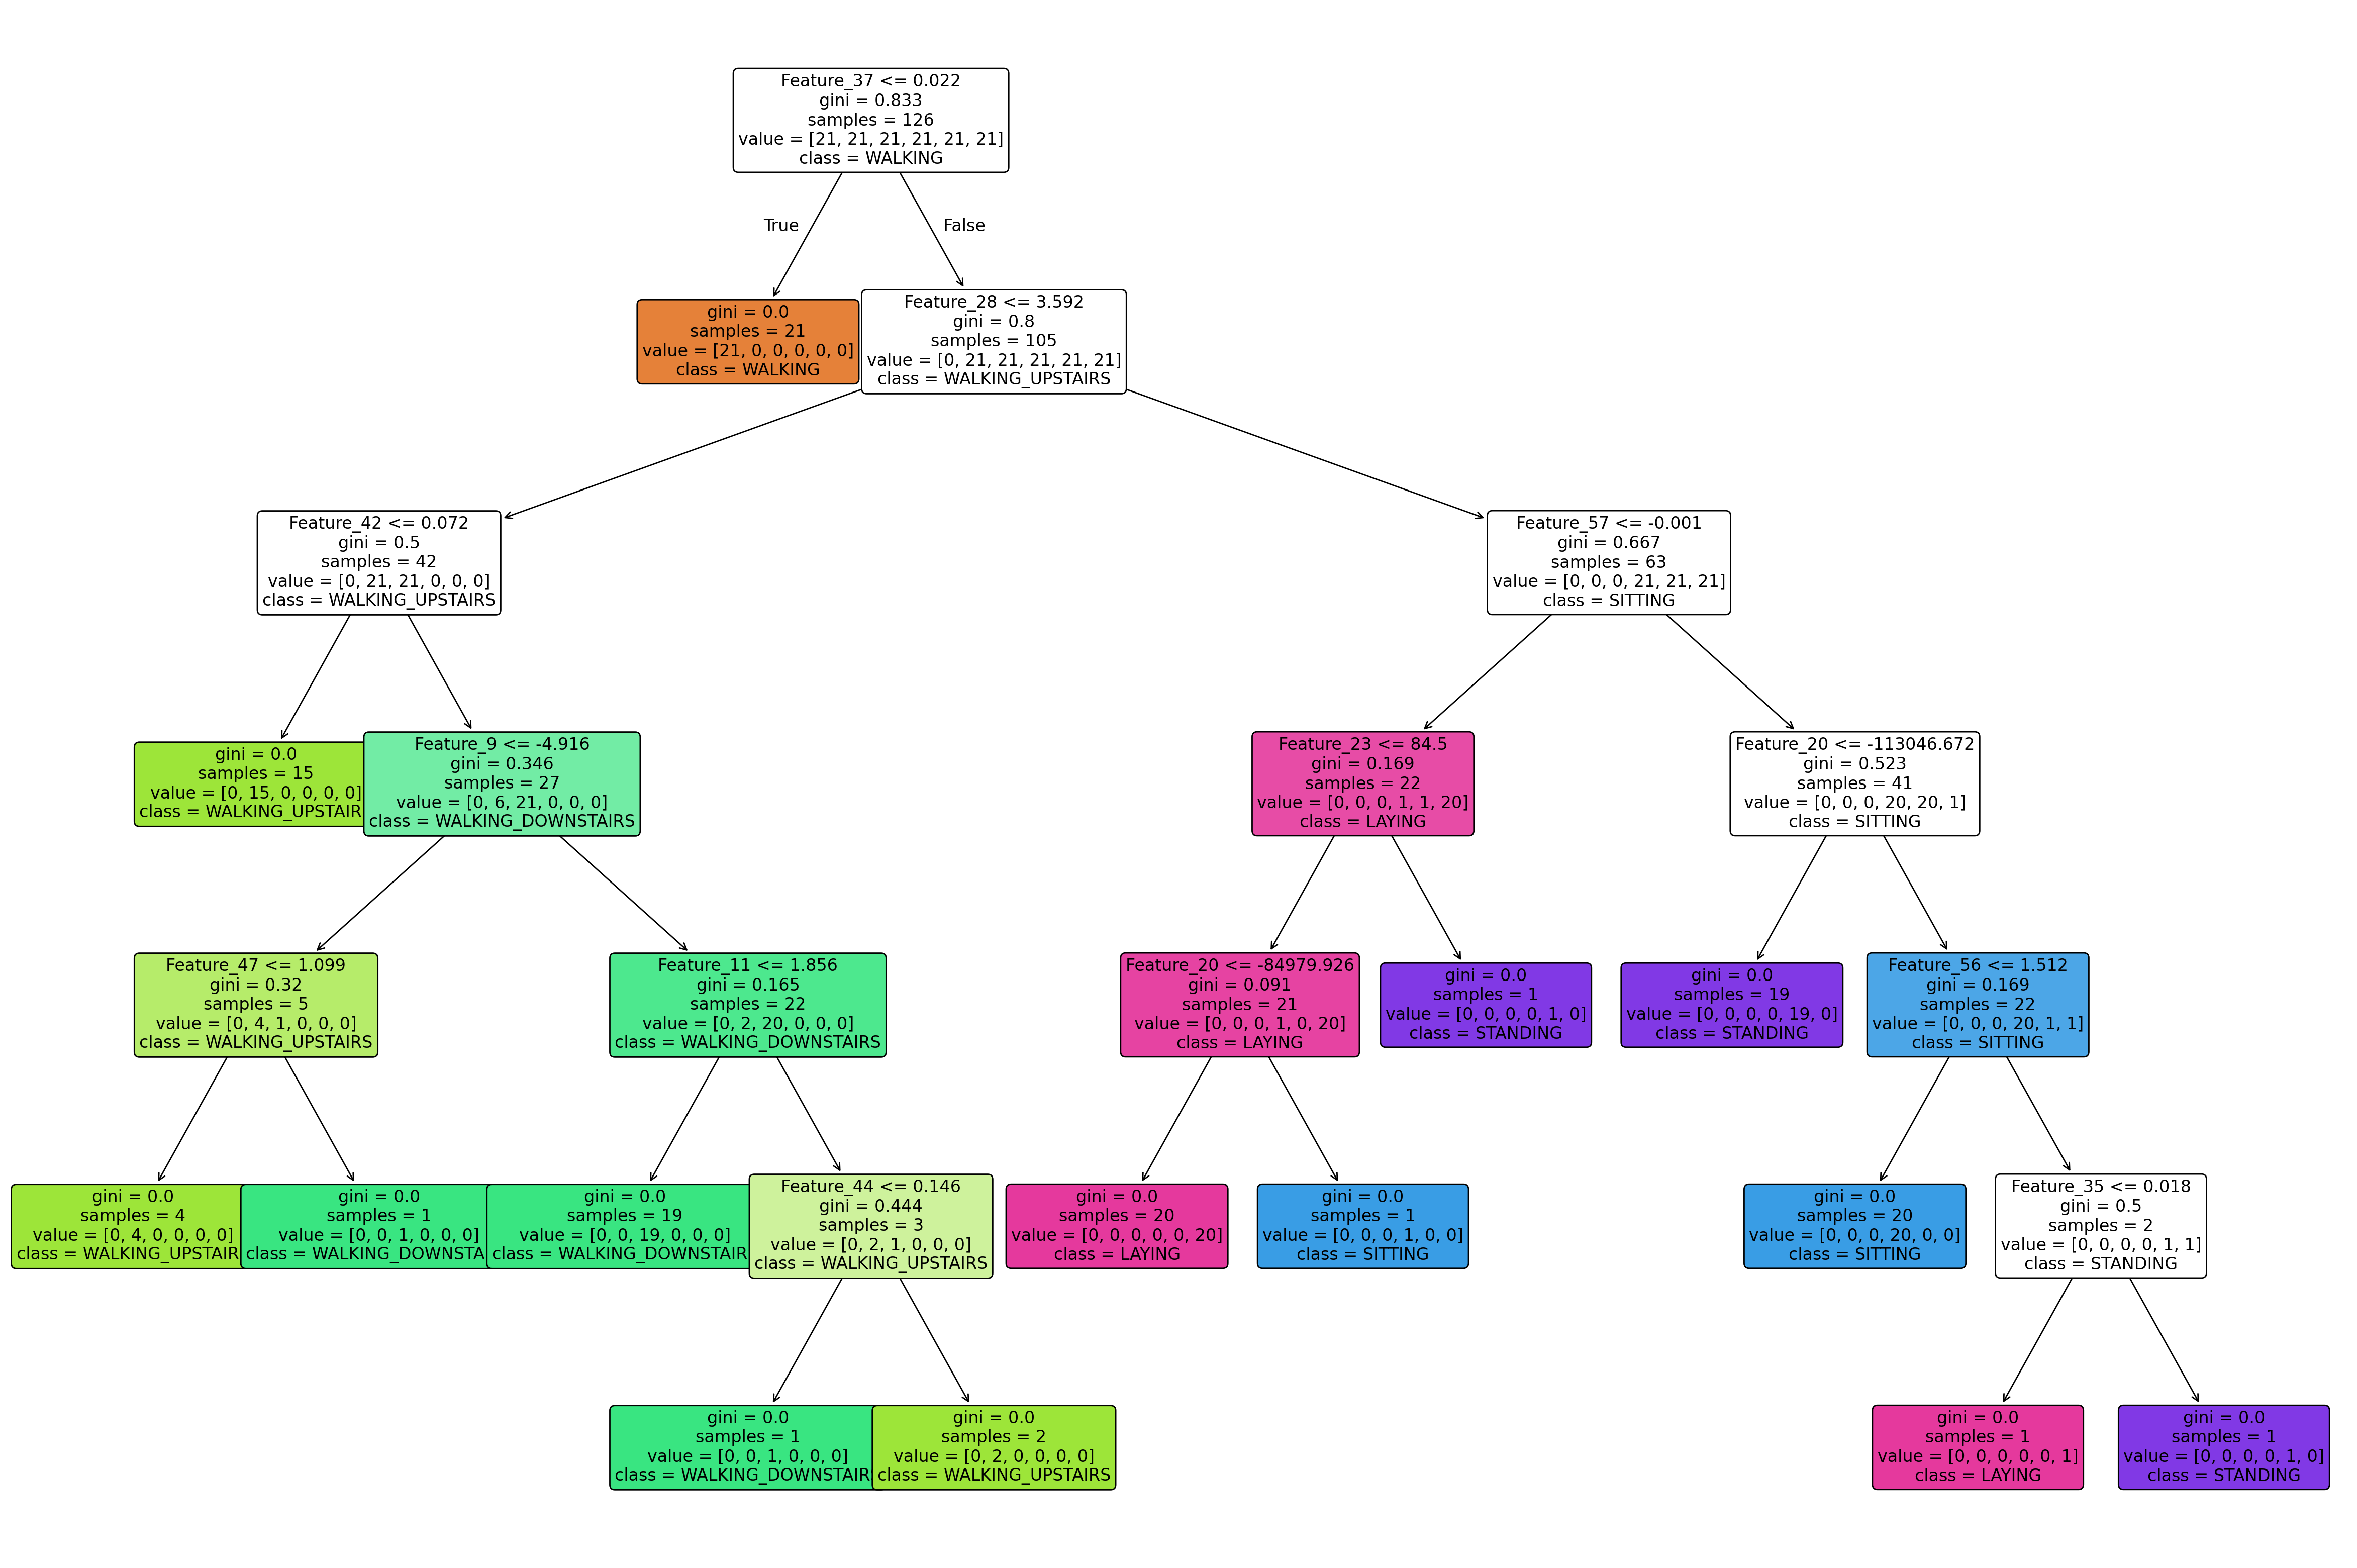

In [ ]:
plt.figure(figsize=(30, 20))
plot_tree(clf, 
          filled=True, 
          rounded=True, 
          feature_names=[f'Feature_{i}' for i in range(X_train_flat.shape[1])], 
          class_names=[classes[i] for i in sorted(classes.keys())],
          fontsize=12)    

plt.show()


#### Confusion Matrix

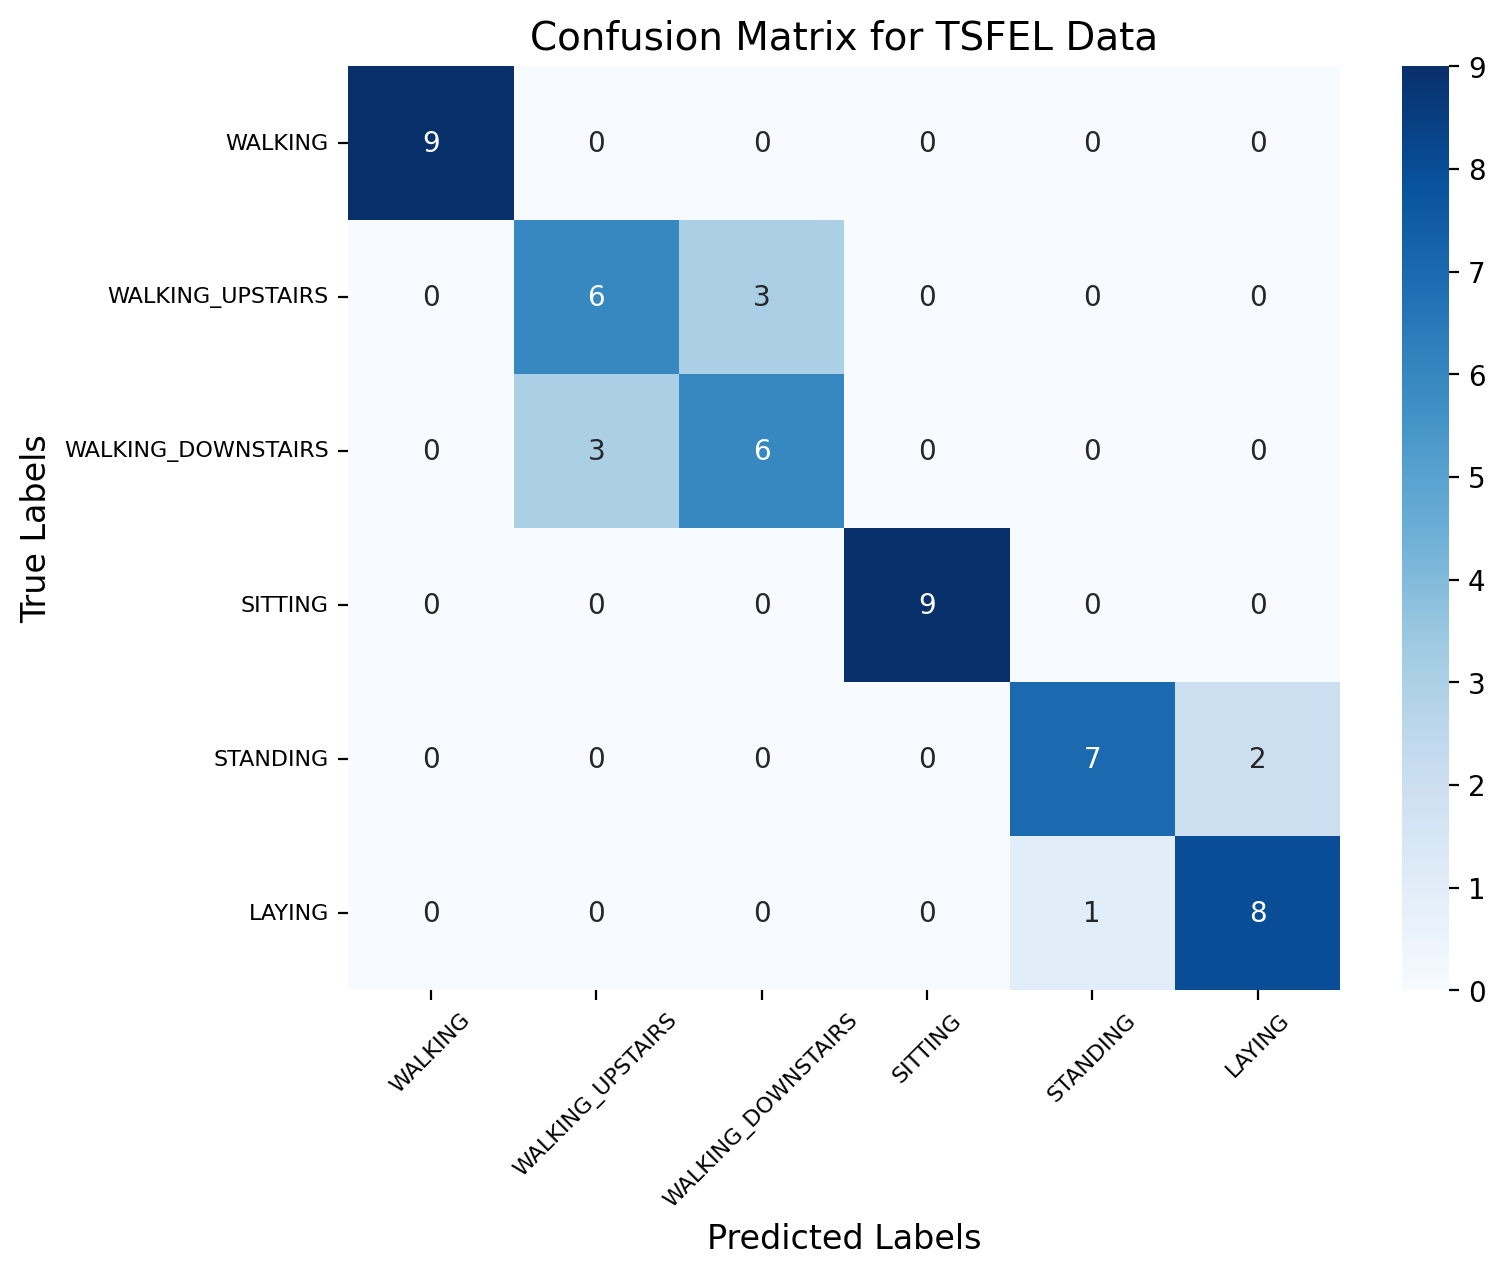

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for TSFEL Data', fontsize=14)
plt.show()


### Decision Tree using UCI HAR Dataset features

#### Here, we are passing the features provided in the UCI HAR dataset as input to the Decision Tree Classifier as follows.
- Loading and Cleaning Feature Names (features.txt): The feature names were loaded from the features.txt file and cleaned by replacing unwanted characters (like dashes) with underscores. Any duplicate feature names were handled by appending unique identifiers to ensure distinct names.
- Dataset Structure (X_train.txt, X_test.txt, y_train.txt, y_test.txt): We use the file MakeHARdataset.py to make the dataset in the same shape as MakeDataset.py for raw accelerometer data. The HAR dataset was organized into a matrix format with the shape (n_subjects, n_activities, n_timesteps, n_features) using the file MakeHARdataset.py. This structure groups the data by each subject and their corresponding activities, with each matrix containing a series of time-steps and features.
- Ensuring Equal Number of Timesteps: To maintain consistency across all data points, the number of time-steps (n_timesteps) was set to the minimum available in the HAR train and test datasets for each subject. This step was done to ensure an equal number of time-steps for each activity to feed to the Decision Tree Classifier. The structured matrix was then flattened into a shape of (n_subjects * n_activities, n_timesteps, n_features).
- Decision Tree Classifier: For the HAR dataset, a Decision Tree Classifier was trained using the flattened data, trained on n_features*n_subjects samples. The accuracy, precision, recall, and confusion matrix were reported for the model.

In [ ]:
from MakeHARdataset import X_train, X_test, y_train, y_test
print(f"X_train shape: {X_train.shape}") # Corresponds to shape(num_subjects * num_activities, num_timesteps, num_features)
print(f"X_test shape: {X_test.shape}") # Corresponds to shape(num_subjects * num_activities, num_timesteps, num_features)
print(f"y_train shape: {y_train.shape}") # Corresponds to shape (num_subjects * num_activities)
print(f"y_test shape: {y_test.shape}") # Corresponds to shape (num_subjects * num_activities)

X_train_flat = X_train.reshape(X_train.shape[0], -1) 
X_test_flat = X_test.reshape(X_test.shape[0], -1)  

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")


Loading feature data from Datasets\UCI HAR Dataset\train...
Loading feature data from Datasets\UCI HAR Dataset\test...
X_train shape: (126, 36, 561)
X_test shape: (54, 36, 561)
y_train shape: (126,)
y_test shape: (54,)
X_train_flat shape: (126, 20196)
X_test_flat shape: (54, 20196)


In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



#### Classification report

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[classes[i] for i in sorted(classes.keys())]))

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

print("Precision, Recall, and Accuracy for each class:")
for i, class_label in enumerate(sorted(classes.keys())):
    class_accuracy = accuracy_score(y_test == class_label, y_pred == class_label)
    print(f"Class {classes[class_label]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, Accuracy = {class_accuracy:.4f}")

# Print overall precision and recall
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"\nOverall Precision (Macro-averaged): {precision_macro}")
print(f"Overall Recall (Macro-averaged): {recall_macro}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")


Classification Report:
                     precision    recall  f1-score   support

           WALKING       0.64      1.00      0.78         9
  WALKING_UPSTAIRS       0.88      0.78      0.82         9
WALKING_DOWNSTAIRS       1.00      0.56      0.71         9
           SITTING       0.88      0.78      0.82         9
          STANDING       0.80      0.89      0.84         9
            LAYING       1.00      1.00      1.00         9

          accuracy                           0.83        54
         macro avg       0.87      0.83      0.83        54
      weighted avg       0.87      0.83      0.83        54

Precision, Recall, and Accuracy for each class:
Class WALKING: Precision = 0.6429, Recall = 1.0000, Accuracy = 0.9444
Class WALKING_UPSTAIRS: Precision = 0.8750, Recall = 0.7778, Accuracy = 0.9259
Class WALKING_DOWNSTAIRS: Precision = 1.0000, Recall = 0.5556, Accuracy = 0.9444
Class SITTING: Precision = 0.8750, Recall = 0.7778, Accuracy = 0.9444
Class STANDING: Precision

#### Visualizing the Decision Tree

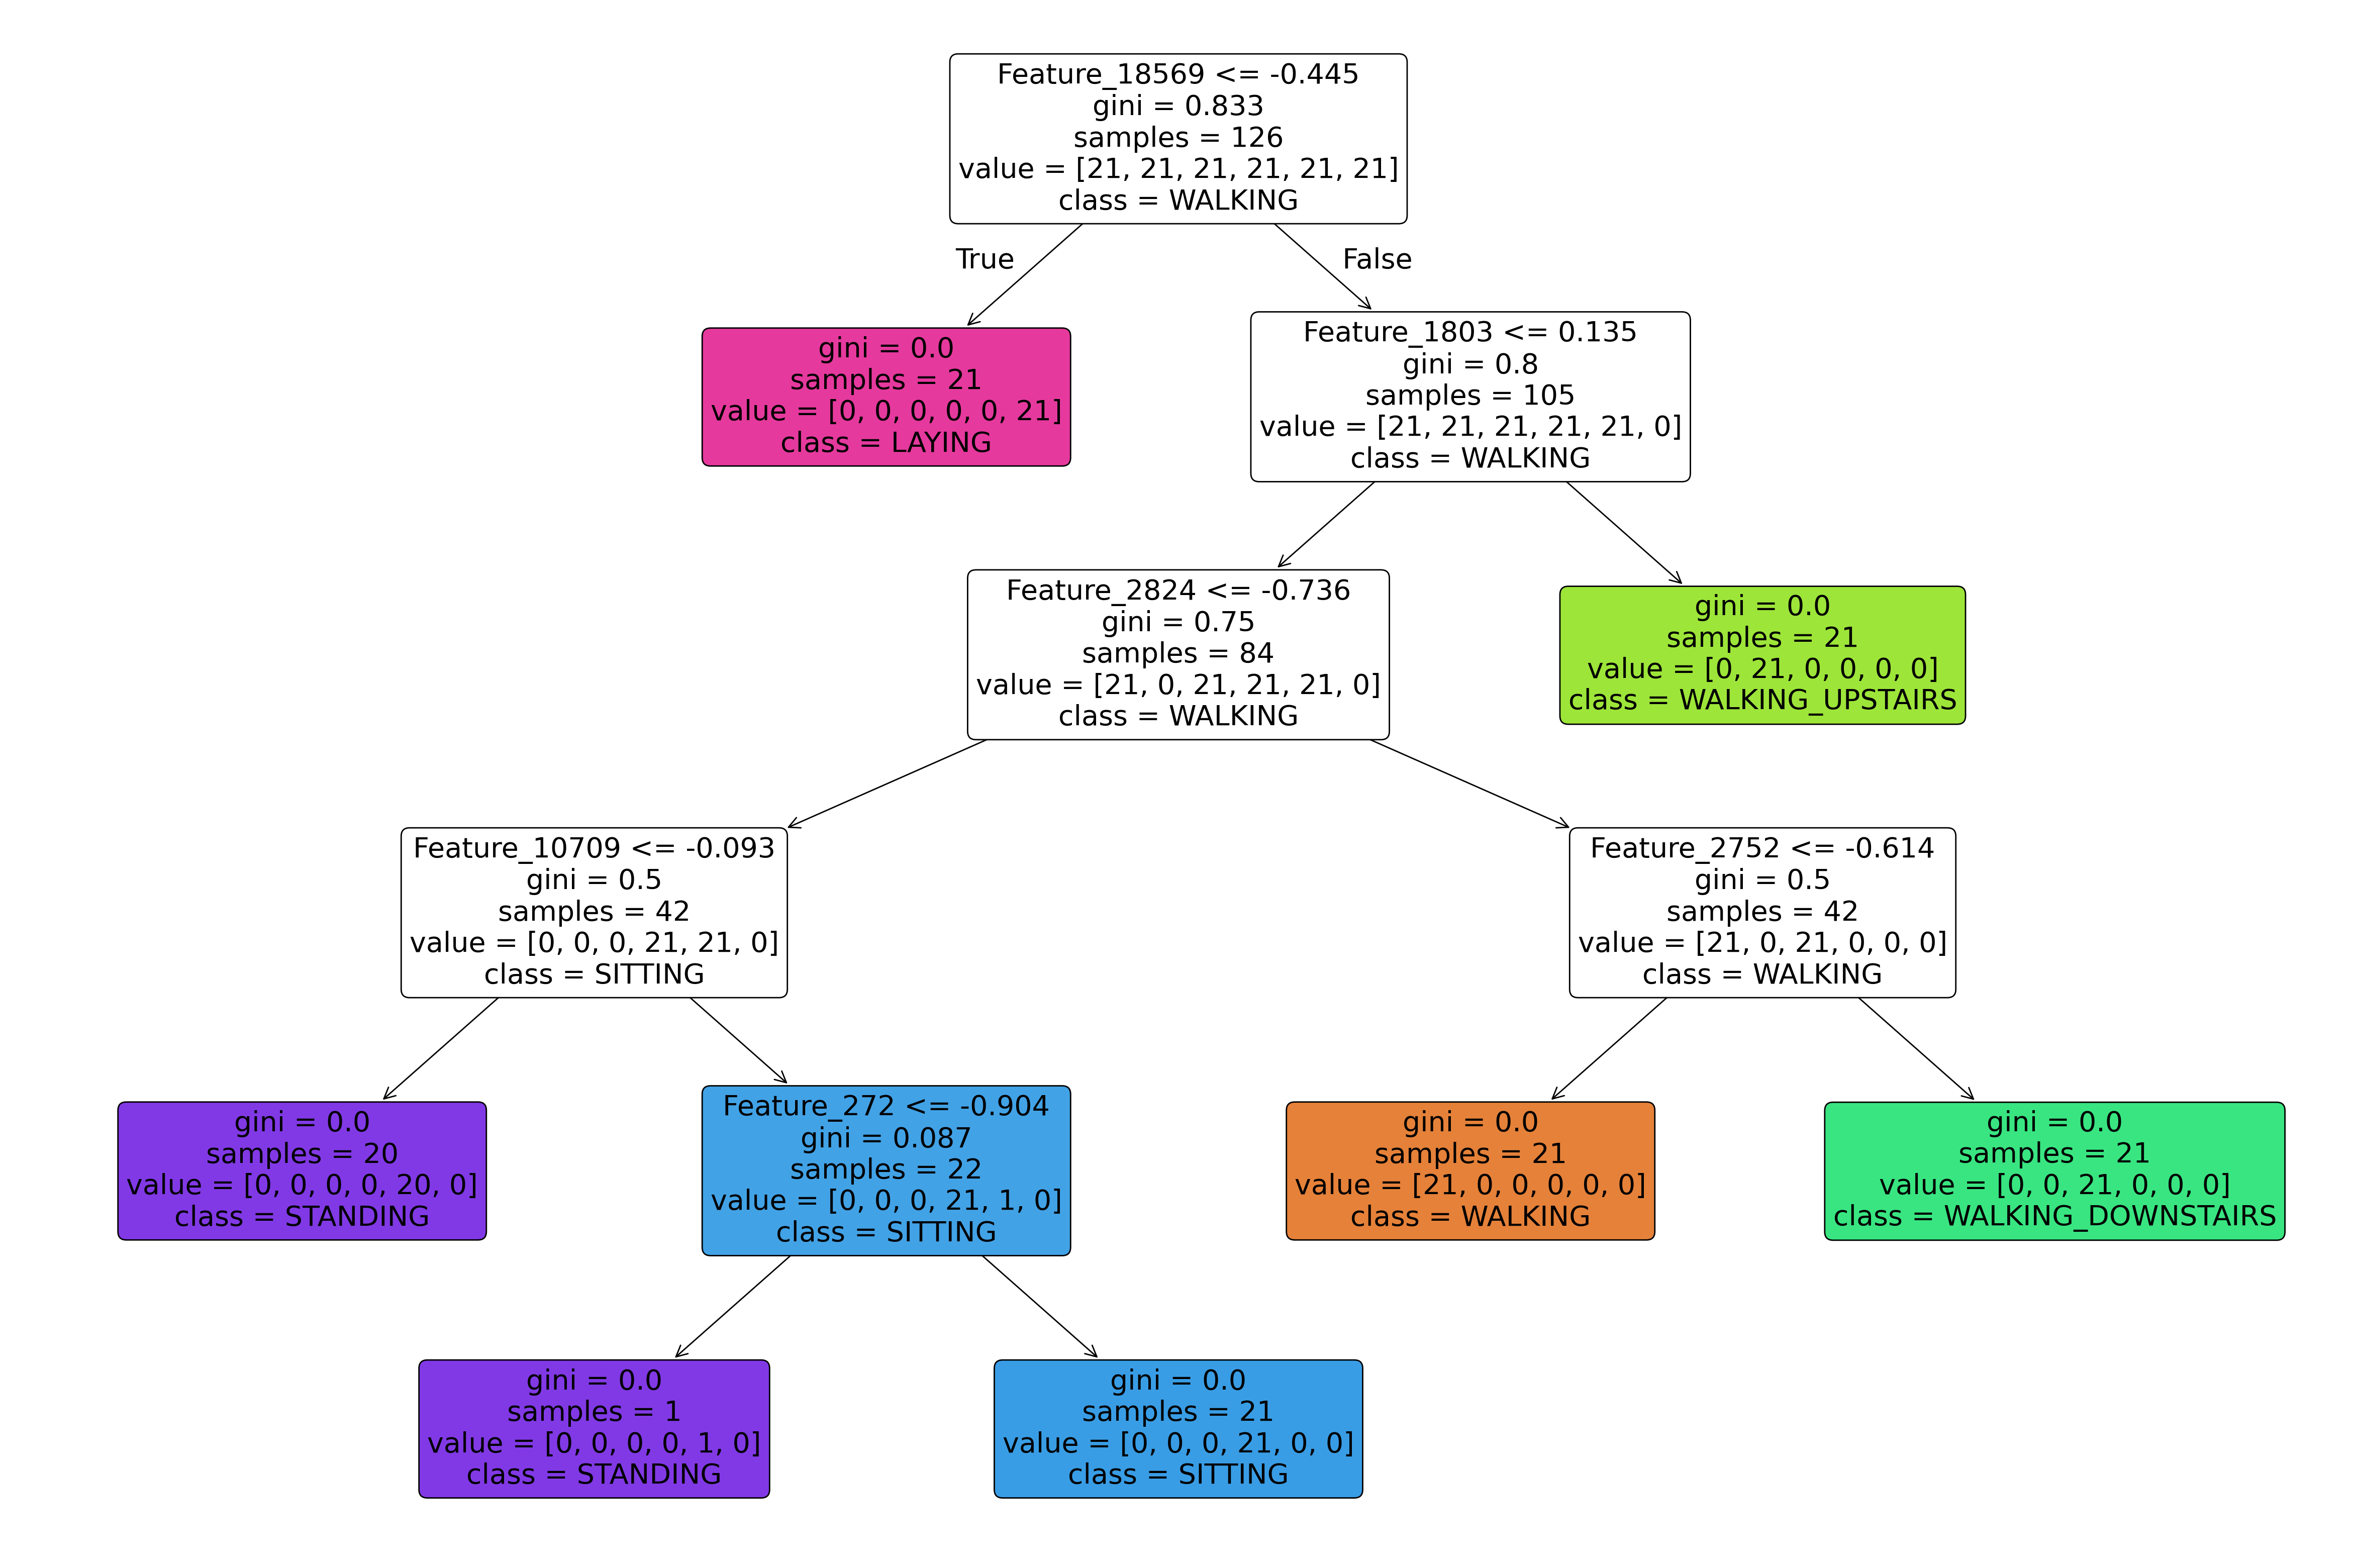

In [ ]:
plt.figure(figsize=(30, 20))
plot_tree(clf, 
          filled=True, 
          rounded=True, 
          feature_names=[f'Feature_{i}' for i in range(X_train_flat.shape[1])], 
          class_names=[classes[i] for i in sorted(classes.keys())],
          fontsize=20)    

plt.show()


#### Confusion Matrix

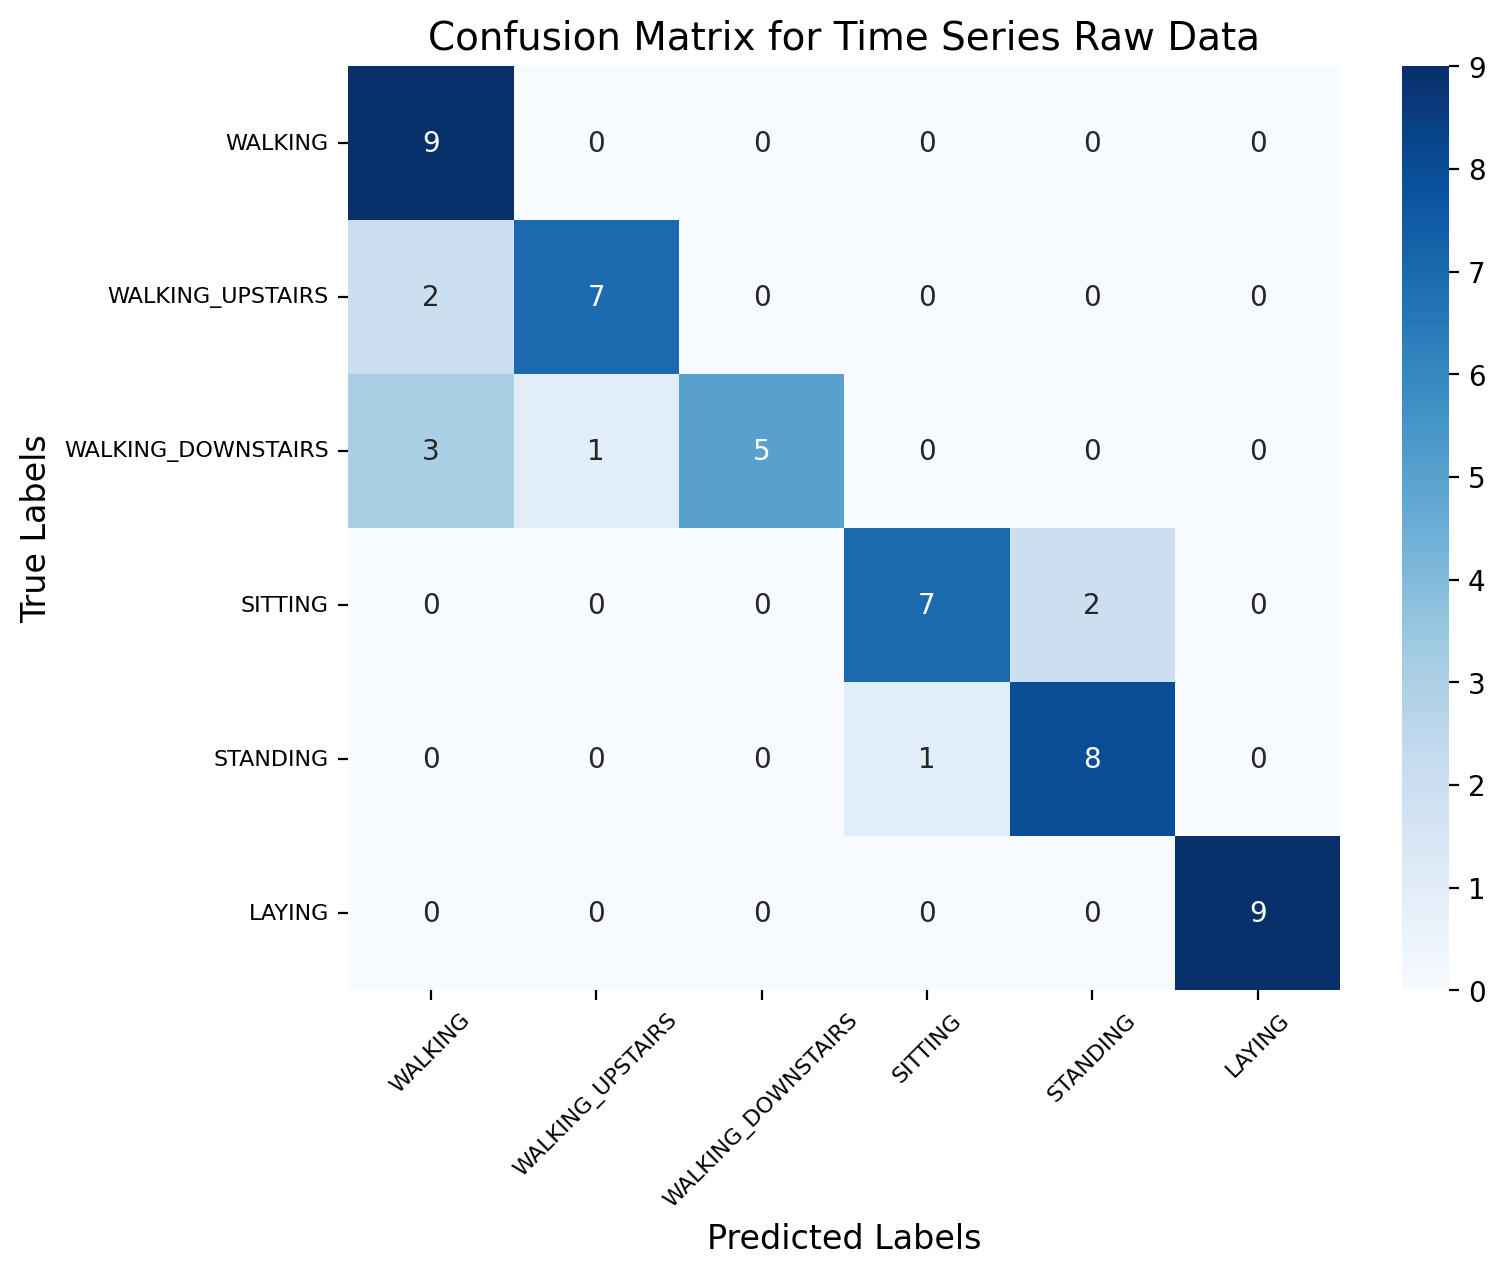

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the Confusion Matrix with class names
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[classes[i] for i in sorted(classes.keys())], 
            yticklabels=[classes[i] for i in sorted(classes.keys())])

# Customize font sizes and rotate yticks
plt.xticks(fontsize=8, rotation=45)  # Smaller font size for xticks
plt.yticks(fontsize=8)  # Smaller font size for yticks and rotate by 45 degrees
plt.xlabel('Predicted Labels', fontsize=12)  # Larger font size for xlabel
plt.ylabel('True Labels', fontsize=12)  # Larger font size for ylabel
plt.title('Confusion Matrix for Time Series Raw Data', fontsize=14)  # Larger font size for title

plt.show()


### Compare the results of the three models. Which model do you think is better?

Here is the summary of the results of all the models

| Model | Accuracy | Precision | Recall |
| --- | --- | --- | --- |
| Raw Accelerometer Data | 59.25% | 0.5949 | 0.5926 |
| TSFEL Features | 83.33% | 0.8347 | 0.8333 |
| UCI HAR Dataset Features | 83.33% | 0.8655 | 0.8333 |

From these results we can conclude that the decision tree model using the TSFEL features and the UCI HAR dataset features performs better than the model using raw accelerometer data. The model using the UCI HAR dataset features has a slightly higher precision than the model using TSFEL features, but both models have the same accuracy and recall. Therefore, the model using the UCI HAR dataset features is the best among the three models.

However, for the UCI HAR dataset features, we have used all the 561 features that were provided in the dataset. But in the TSFEL features, we have used only 60 features.

## 2. Accuracy vs Depth of Decision Tree

### For raw accelerometer data

Hyperparameters kept constant across different depths:
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
random_state: 0
splitter: best


Depth: 2, Train Accuracy: 47.62%, Test Accuracy: 42.59%
Depth: 3, Train Accuracy: 61.90%, Test Accuracy: 53.70%
Depth: 4, Train Accuracy: 80.16%, Test Accuracy: 59.26%
Depth: 5, Train Accuracy: 91.27%, Test Accuracy: 57.41%
Depth: 6, Train Accuracy: 97.62%, Test Accuracy: 59.26%
Depth: 7, Train Accuracy: 99.21%, Test Accuracy: 57.41%
Depth: 8, Train Accuracy: 100.00%, Test Accuracy: 59.26%


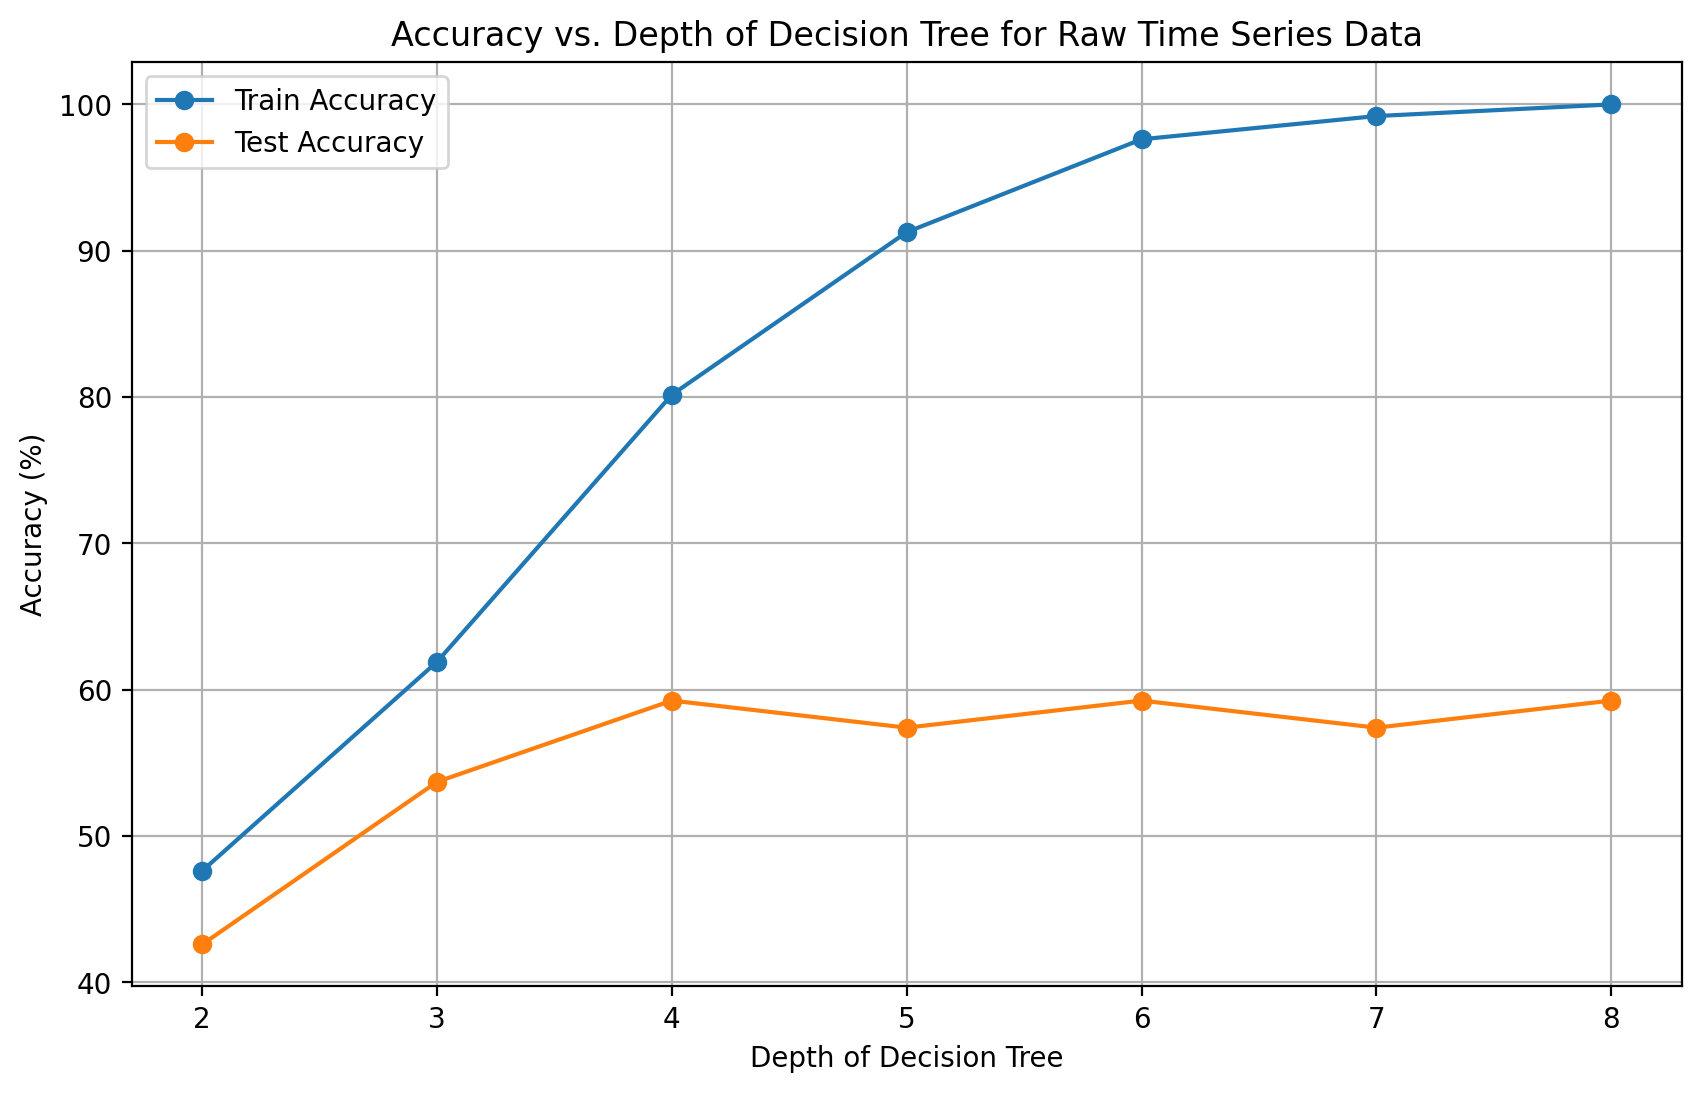

In [ ]:
# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

# Define the range of depths to be tested
depths = range(2, 9)

# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []

# Initialize a classifier with a fixed depth to get the default hyperparameters
clf_default = DecisionTreeClassifier(random_state=0)
default_params = clf_default.get_params()

# Remove the max_depth parameter since we are varying it
default_params.pop('max_depth')

# Print the hyperparameters that are kept constant
print("Hyperparameters kept constant across different depths:")
for param, value in default_params.items():
    print(f"{param}: {value}")

print("\n")  # Adding space before the loop starts printing the accuracy results

# Loop through each depth, train the model, and calculate accuracy
for depth in depths:
    # Initialize the Decision Tree Classifier with the specified depth
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train_flat, y_train)
    
    # Predictions on the training and test sets
    y_train_pred = clf.predict(X_train_flat)
    y_test_pred = clf.predict(X_test_flat)
    
    # Calculate accuracy for training and test sets
    train_accuracy = accuracy_score(y_train, y_train_pred) * 100
    test_accuracy = accuracy_score(y_test, y_test_pred) * 100
    
    # Append the accuracies to the respective lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    # Print the results for each depth
    print(f"Depth: {depth}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

# Plot the accuracy vs. depth
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(depths, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Accuracy vs. Depth of Decision Tree for Raw Time Series Data')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy (%)')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()


### For TSEFL feature data

Hyperparameters kept constant across different depths:
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
random_state: 0
splitter: best


Depth: 2, Train Accuracy: 50.00%, Test Accuracy: 50.00%
Depth: 3, Train Accuracy: 76.98%, Test Accuracy: 74.07%
Depth: 4, Train Accuracy: 95.24%, Test Accuracy: 81.48%
Depth: 5, Train Accuracy: 98.41%, Test Accuracy: 85.19%
Depth: 6, Train Accuracy: 100.00%, Test Accuracy: 83.33%
Depth: 7, Train Accuracy: 100.00%, Test Accuracy: 83.33%
Depth: 8, Train Accuracy: 100.00%, Test Accuracy: 83.33%


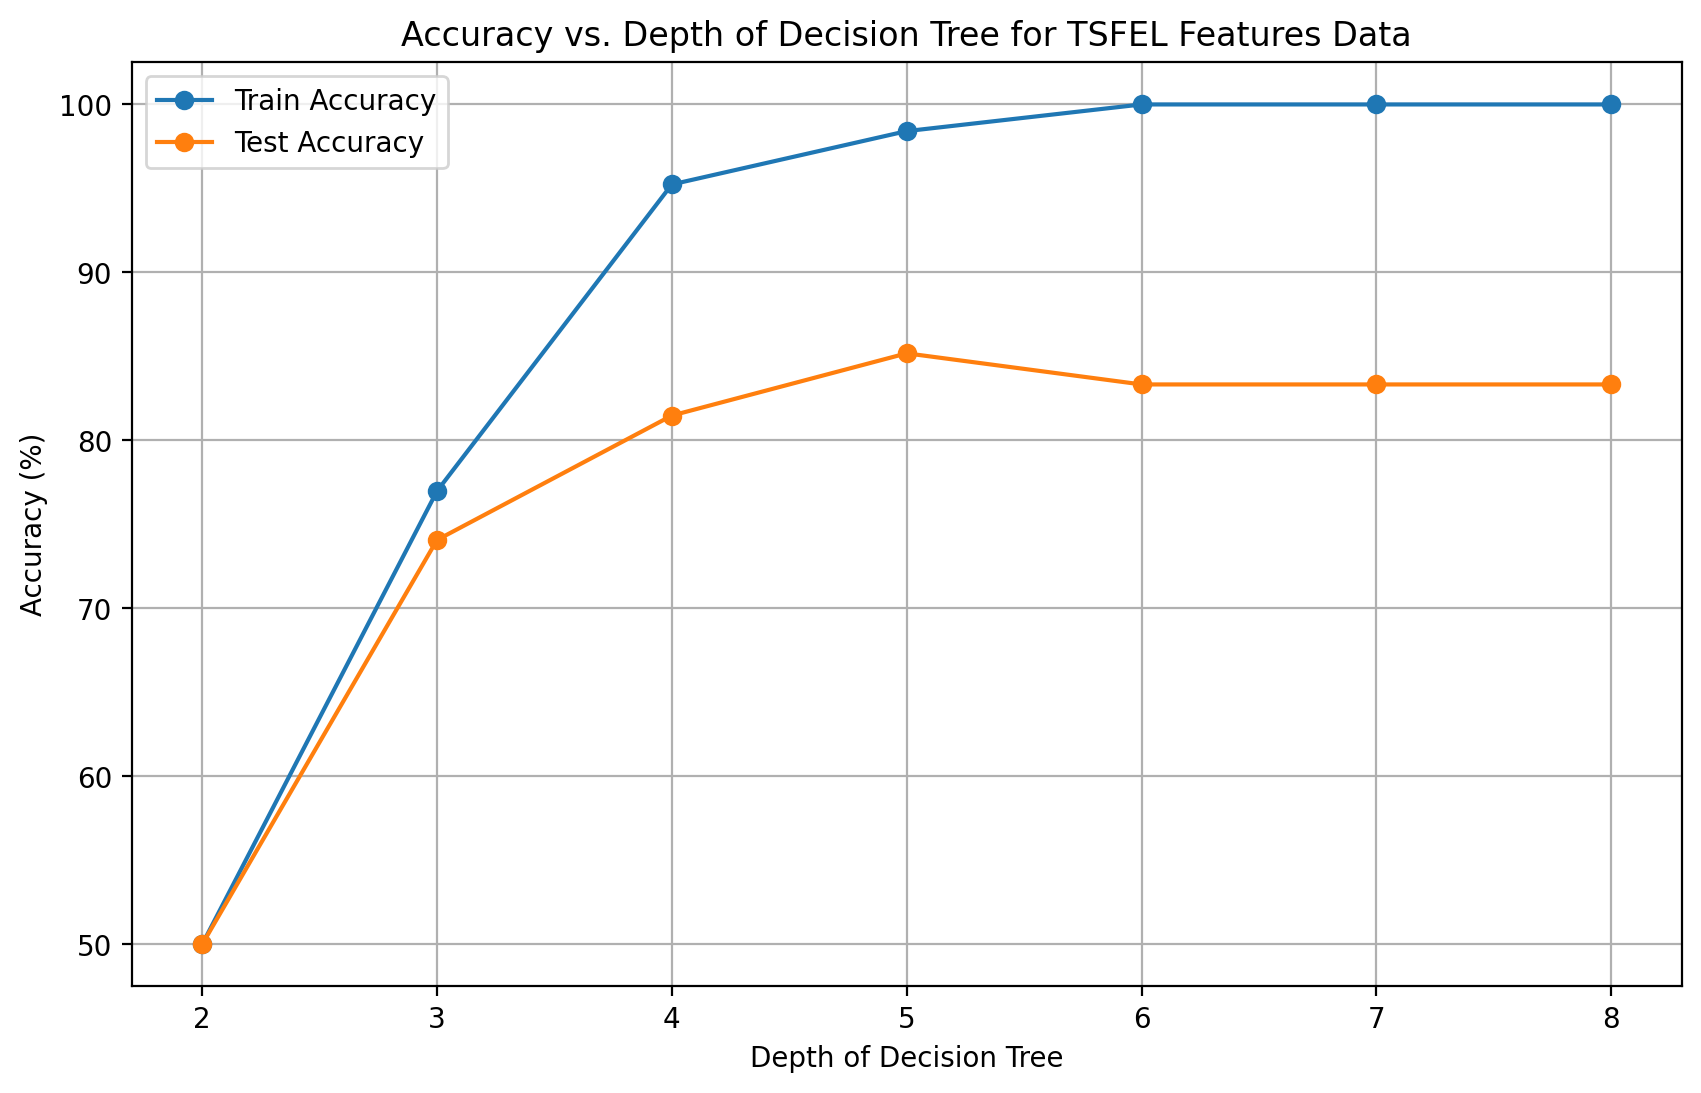

In [ ]:
# Define the base directory path
base_dir = 'Datasets/TSFEL_3axes_filteredfeatures'  

# Load Train and Test datasets
X_train, y_train = load_tsfel_dataset(base_dir, 'Train')
X_test, y_test = load_tsfel_dataset(base_dir, 'Test')

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  
X_test_flat = X_test.reshape(X_test.shape[0], -1) 

# Define the range of depths to be tested
depths = range(2, 9)

# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []

# Initialize a classifier with a fixed depth to get the default hyperparameters
clf_default = DecisionTreeClassifier(random_state=0)
default_params = clf_default.get_params()

# Remove the max_depth parameter since we are varying it
default_params.pop('max_depth')

# Print the hyperparameters that are kept constant
print("Hyperparameters kept constant across different depths:")
for param, value in default_params.items():
    print(f"{param}: {value}")

print("\n")  # Adding space before the loop starts printing the accuracy results

# Loop through each depth, train the model, and calculate accuracy
for depth in depths:
    # Initialize the Decision Tree Classifier with the specified depth
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train_flat, y_train)
    
    # Predictions on the training and test sets
    y_train_pred = clf.predict(X_train_flat)
    y_test_pred = clf.predict(X_test_flat)
    
    # Calculate accuracy for training and test sets
    train_accuracy = accuracy_score(y_train, y_train_pred) * 100
    test_accuracy = accuracy_score(y_test, y_test_pred) * 100
    
    # Append the accuracies to the respective lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    # Print the results for each depth
    print(f"Depth: {depth}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

# Plot the accuracy vs. depth
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(depths, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Accuracy vs. Depth of Decision Tree for TSFEL Features Data')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy (%)')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()


### For HAR data

Hyperparameters kept constant across different depths:
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
random_state: 0
splitter: best


Depth: 2, Train Accuracy: 50.00%, Test Accuracy: 46.30%
Depth: 3, Train Accuracy: 66.67%, Test Accuracy: 62.96%
Depth: 4, Train Accuracy: 99.21%, Test Accuracy: 85.19%
Depth: 5, Train Accuracy: 100.00%, Test Accuracy: 83.33%
Depth: 6, Train Accuracy: 100.00%, Test Accuracy: 83.33%
Depth: 7, Train Accuracy: 100.00%, Test Accuracy: 83.33%
Depth: 8, Train Accuracy: 100.00%, Test Accuracy: 83.33%


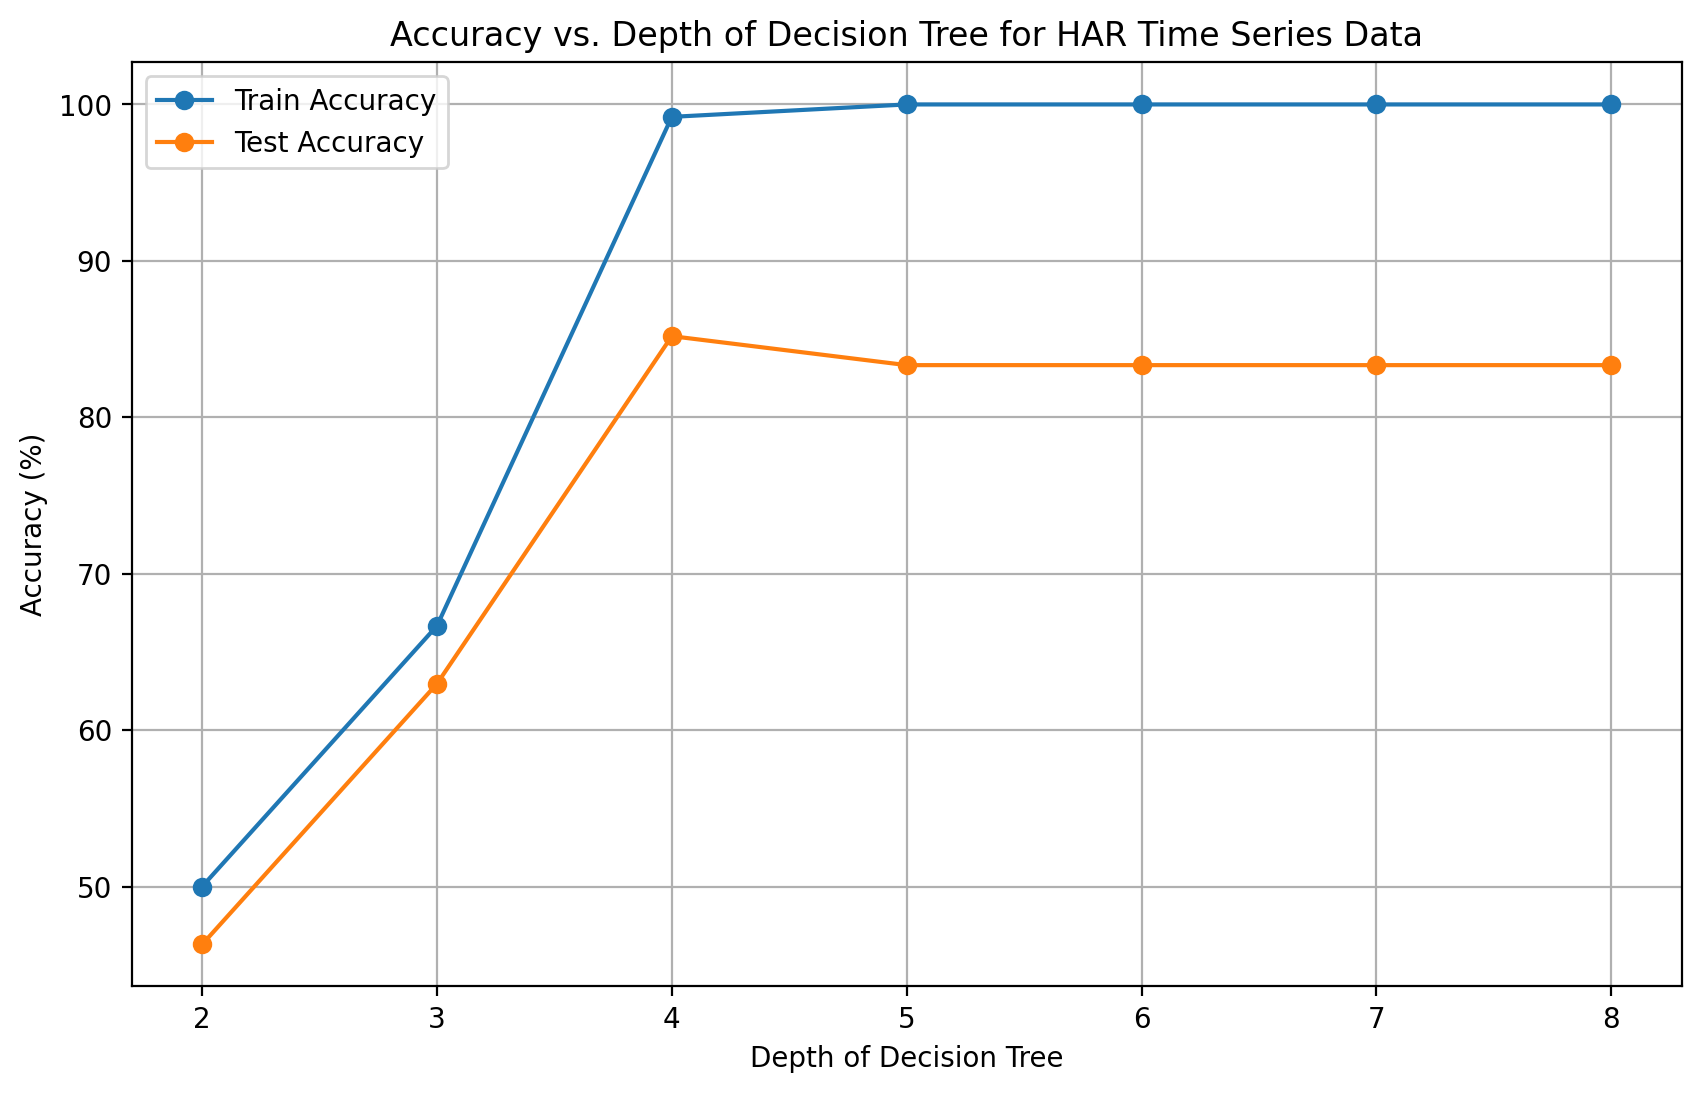

In [ ]:
# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

# Define the range of depths to be tested
depths = range(2, 9)

# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []

# Initialize a classifier with a fixed depth to get the default hyperparameters
clf_default = DecisionTreeClassifier(random_state=0)
default_params = clf_default.get_params()

# Remove the max_depth parameter since we are varying it
default_params.pop('max_depth')

# Print the hyperparameters that are kept constant
print("Hyperparameters kept constant across different depths:")
for param, value in default_params.items():
    print(f"{param}: {value}")

print("\n")  # Adding space before the loop starts printing the accuracy results

# Loop through each depth, train the model, and calculate accuracy
for depth in depths:
    # Initialize the Decision Tree Classifier with the specified depth
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train_flat, y_train)
    
    # Predictions on the training and test sets
    y_train_pred = clf.predict(X_train_flat)
    y_test_pred = clf.predict(X_test_flat)
    
    # Calculate accuracy for training and test sets
    train_accuracy = accuracy_score(y_train, y_train_pred) * 100
    test_accuracy = accuracy_score(y_test, y_test_pred) * 100
    
    # Append the accuracies to the respective lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    # Print the results for each depth
    print(f"Depth: {depth}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

# Plot the accuracy vs. depth
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(depths, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Accuracy vs. Depth of Decision Tree for HAR Time Series Data')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy (%)')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()

## 3. Are there any participants/ activitivies where the Model performace is bad? If Yes, Why? [0.5 mark]

### Passing in Raw Accelerometer Data:
The Precision, Recall and the F1 score is the worst on walking, followed by walking downstairs and walking upstairs. Similar conclusion can be derived by looking at the confusion matrix for the same 3 classes. The best accuracy is for laying, standing and sitting. This is most likely because they are static activities and hence from the plots shown in task 1, we can predict that the decision tree will perform better in classifying these activities.

### Passing in TSFEL Data:
From the confusion matrix, we can see that the highest accuracy is on walking, and sitting task, where there are no errors. However, the model struggles in classifying, climbing as upstairs or downstairs. This is also evident from the graphs which we saw in task 1, where walking upstairs and downstairs had a visually similar graph. Same seems to be the case in standing and laying.

### UCI HAR
From the confusion matrix, we can see that there is misclassification of a few data points for walking, walking upstairs and walking downstairs. This can be attributed to visually similar features in task 1. Some errors in classification are also observed between sitting and standing. No errors in classification were observed in laying.

From both of the above featurised data, we can see that the model has no errors in classifying static or dynamic activities.

In general all the models have difficulty in classifying walking upstairs and walking downstairs (or the dynamic activities). This is because the features of these activities are visually similar and hence the model has difficulty in distinguishing between them. The model performs well in classifying static activities like sitting, standing and laying.

## Extra: Code for hyperparameter tuning

### Decision Tree Hyperparameter Tuning: A GridSearchCV Approach

In this write-up, we will discuss the range of values for each hyperparameter to be tuned using `GridSearchCV` and provide justifications for why certain hyperparameters are chosen for optimization while others are not.

### 1. `criterion`
- **Description**: The function to measure the quality of a split.
- **Range**: `['gini', 'entropy']`
- **Reasoning**: *Gini impurity* and *Information Gain (Entropy)* are the two most commonly used criteria for splitting. Both have their merits, and the best choice can vary depending on the specific dataset.

### 2. `max_depth`
- **Description**: The maximum depth of the tree.
- **Range**: `[None, 5, 10, 15, 20, 30]`
- **Reasoning**: Limiting the depth of the tree is crucial for preventing overfitting. `None` allows the tree to grow fully, while specific values like `5` to `30` help control the tree's complexity. Cross-validation will help identify the optimal depth.

### 3. `min_samples_split`
- **Description**: The minimum number of samples required to split an internal node.
- **Range**: `[2, 5, 10, 20, 50]`
- **Reasoning**: Higher values reduce the model's tendency to overfit by requiring more data to create a split. This is particularly useful when dealing with smaller datasets.

### 4. `min_samples_leaf`
- **Description**: The minimum number of samples required to be at a leaf node.
- **Range**: `[1, 2, 5, 10, 20]`
- **Reasoning**: Similar to `min_samples_split`, this parameter controls the minimum size of leaf nodes, preventing the model from learning overly specific patterns (overfitting).

### 5. `max_features`
- **Description**: The number of features to consider when looking for the best split.
- **Range**: `['auto', 'sqrt', 'log2', None]`
- **Reasoning**: Limiting the number of features can reduce overfitting and speed up computation, particularly in datasets with a large number of features. Exploring these options can help find the best setting.

### 6. `ccp_alpha`
- **Description**: Complexity parameter for Minimal Cost-Complexity Pruning.
- **Range**: `[0.0, 0.01, 0.1, 0.001]`
- **Reasoning**: Pruning the tree can help reduce complexity and overfitting. The exact value for `ccp_alpha` will depend on the dataset, and tuning this parameter helps find the right balance.

### 7. `splitter`
- **Description**: The strategy used to choose the split at each node.
- **Range**: `['best', 'random']`
- **Reasoning**: The `'best'` option tries to find the best possible split at each node, while `'random'` can introduce some randomness in the process. This randomness can sometimes lead to better generalization, particularly in large datasets.

### 8. `min_impurity_decrease`
- **Description**: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
- **Range**: `[0.0, 0.01, 0.1, 0.001]`
- **Reasoning**: Tuning this parameter can prevent the tree from splitting on nodes that do not significantly reduce impurity, thereby controlling tree growth and avoiding overfitting.

### Hyperparameters Not Chosen for Optimization

- **`class_weight`**: This parameter is more relevant when dealing with imbalanced datasets. Since the primary goal here is not to handle class imbalance specifically, it is not included in the primary grid search. However, if class imbalance is a concern, setting `class_weight` to `'balanced'` is often sufficient.
  
- **`min_weight_fraction_leaf`**: This parameter is generally useful only when dealing with weighted datasets, which is not the case here. It is a more specialized parameter and not as impactful for most general classification problems.
  
- **`monotonic_cst`**: This parameter enforces monotonicity constraints on features, which is not relevant for most classification tasks unless there is a specific need to enforce such relationships.
  
- **`random_state`**: `random_state` is used for ensuring reproducibility of results and does not affect the model's performance or complexity, so it is not a parameter for optimization.



In [ ]:
X_combined = np.concatenate((X_train_flat, X_test_flat), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'ccp_alpha': [0.0, 0.01, 0.1],
    'min_impurity_decrease': [0.0, 0.01, 0.1, 0.001]
}

clf = DecisionTreeClassifier(random_state=42)

scorer = make_scorer(accuracy_score)

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer, cv=inner_cv, n_jobs=-1)

results = []

nested_scores = []
for i, (train_index, test_index) in enumerate(tqdm(outer_cv.split(X_combined), total=outer_cv.get_n_splits(), desc="Outer CV Progress")):
    X_train, X_test = X_combined[train_index], X_combined[test_index]
    y_train, y_test = y_combined[train_index], y_combined[test_index]
    
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    score = accuracy_score(y_test, grid_search.predict(X_test))
    nested_scores.append(score)
    
    results.append({
        'outer_fold': i + 1,
        'inner_best_params': best_params,
        'inner_best_score': grid_search.best_score_,
        'outer_test_score': score
    })
    
    print(f"Best Hyperparameters for Fold {i + 1}:\n", best_params)

results_df = pd.DataFrame(results)
results_df.to_csv('Asst#2_nested_cv_results.csv', index=False)

grid_search.fit(X_combined, y_combined)

print("Best Hyperparameters across all data:\n", grid_search.best_params_)

nested_scores = np.array(nested_scores)
print(f"\nNested Cross-Validation Accuracy Scores: {nested_scores}")
print(f"Mean Nested Cross-Validation Accuracy: {nested_scores.mean():.4f}")


Outer CV Progress:  20%|██        | 1/5 [10:34<42:18, 634.66s/it]

Best Hyperparameters for Fold 1:
 {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2}


Outer CV Progress:  40%|████      | 2/5 [20:30<30:34, 611.67s/it]

Best Hyperparameters for Fold 2:
 {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2}


Outer CV Progress:  60%|██████    | 3/5 [32:08<21:42, 651.31s/it]

Best Hyperparameters for Fold 3:
 {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 20}


Outer CV Progress:  80%|████████  | 4/5 [42:13<10:32, 632.75s/it]

Best Hyperparameters for Fold 4:
 {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 20}


Outer CV Progress: 100%|██████████| 5/5 [52:16<00:00, 627.21s/it]

Best Hyperparameters for Fold 5:
 {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 20}


Best Hyperparameters across all data:
 {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2}

Nested Cross-Validation Accuracy Scores: [0.77777778 0.91666667 0.88888889 0.83333333 0.80555556]
Mean Nested Cross-Validation Accuracy: 0.8444
